In [ ]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0


In [ ]:
!pip install tensorflow==1.13.2

     |████████████████████████████████| 92.6MB 47kB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 3.2MB 48.3MB/s 
     |████████████████████████████████| 368kB 54.6MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/CCTV_Model

/content/drive/MyDrive/CCTV_Model


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from loader import *
from network import *

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
ph = tf.placeholder('float', [None, None])
phhl = tf.placeholder('float') #hinge_loss

In [ ]:
Anomaly, Normal = fetch_training_data("./data")

In [ ]:
output , parameters_1 , parameters_2, parameters_3 = define_network(ph)
loss = 0.001 * (tf.nn.l2_loss(parameters_1) + tf.nn.l2_loss(parameters_2) + tf.nn.l2_loss(parameters_3)) + phhl
optimizer = tf.train.AdagradOptimizer(0.001).minimize(loss)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.


In [ ]:
trained_model_saver = tf.train.Saver()  # to save model

In [ ]:
# Storing details for tensorboard
tf.summary.scalar('cost', loss)
tf.summary.histogram('h_w1', parameters_1)
tf.summary.histogram('h_w2', parameters_2)
tf.summary.histogram('h_w3', parameters_3)
merged_summary_op = tf.summary.merge_all()

In [ ]:
# Initialize and run
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [ ]:
epochs = 12500
print_epoch = 20
save_model_epoch = 500
count = 0

In [ ]:
loss_plot =[] #loss array

train_writer = tf.summary.FileWriter("./logs/Dnn_session",tf.get_default_graph())

for epoch in range(epochs):

    i=0
    anomalous, normal = fetch_training_data("./data") # getting data

    while i < len(anomalous):

        start = i

        end =i+batch_size

        batch_x =np.array(anomalous[start:end])
        batch_y =np.array(normal[start:end])  # Single Video of normal and anomolus


        anomaly_score = sess.run(output,feed_dict={ph: batch_x})
        normal_score, W1= sess.run([output,parameters_1],feed_dict={ph: batch_y})  # calaculated score of anomolus and normal video

        # calculation of hinge loss-------------------------------------------------
        anomaly_score = anomaly_score.flatten()
        normal_score = normal_score.flatten()

        l = max(0.0,(1-anomaly_score.max()+normal_score.max())) #loss implementation

        add = 0.0
        for index in range(len(anomaly_score) - 1):
            add += (anomaly_score[index] - anomaly_score[index+1]) ** 2

        final_loss = l + (add*1.0 + anomaly_score.sum()) * 0.00008 

        # loss completed----------------------------------------------------------

        o,_,cst,summ = sess.run([optimizer,output,loss,merged_summary_op], feed_dict={phhl : final_loss,ph: batch_x})


        i =i + batch_size

        train_writer.add_summary(summ,count) # summaries for tensorBoard

        count += 1
    
    loss_plot.append(cst)

    if epoch %print_epoch ==1:
        print('Epoch', epoch, 'completed out of',epochs,'loss:',cst)

    if epoch%save_model_epoch == 1:
        saved_path = trained_model_saver.save(sess, './model/model', global_step=epoch)


Epoch 1 completed out of 500 loss: 1056.7137
Epoch 21 completed out of 500 loss: 1052.7397


KeyboardInterrupt: ignored

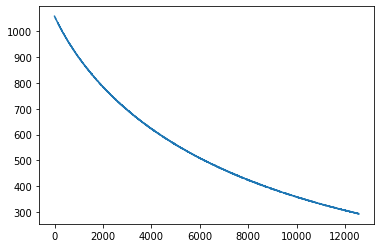

In [ ]:
plt.plot(loss_plot)